# Abstract


Medium voltage overhead power lines run for hundreds of miles to supply power to cities. These great distances make it expensive to manually inspect the lines for damage that doesn't immediately lead to a power outage, such as a tree branch hitting the line or a flaw in the insulator. These modes of damage lead to a phenomenon known as partial discharge — an electrical discharge which does not bridge the electrodes between an insulation system completely. Partial discharges slowly damage the power line, so left unrepaired they will eventually lead to a power outage or start a fire.

My aim is to detect partial discharge patterns in signals acquired from these power lines. By developing a solution to detect partial discharge there will be reduced maintenance costs, and will prevent power outages.

The main task here is to evaluate 'Matthews Correlation Coefficient' between the predicted and the observed response.

The MCC is given by the following formula -

                         MCC =         (TP∗TN)−(FP∗FN)
                               -----------------------------
                               √(TP+FP)(TP+FN)(TN+FP)(TN+FN)
                               
                   

I am predicting a binary prediction for the target variable. The file will contain a header and have the following format:

signal_id,target
0,0
1,1
2,0
etc.

# The Data

id_measurement: the ID code for a trio of signals recorded at the same time.

signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test, so the first ID in train is '0' but the first ID in test is '8712'.

phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.

target: 0 if the power line is undamaged, 1 if there is a fault.


# Explanations of the analysis and interpretations of figures and graphs

Detailed explanations of graph and code is given as the notebook progresses.

In [1]:
import copy
import gc
import os
import sys
import warnings

from IPython.core.display import display, HTML
import pyarrow.parquet as pq # Used to read the data
import lightgbm as lgb
from matplotlib import pyplot as plt
import numba
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns 
import sklearn
from sklearn.metrics import matthews_corrcoef, precision_recall_fscore_support

"""
My first Kaggle competition.
Thank you so much mark4h for your 
wonderful solutions.
Source - https://www.kaggle.com/mark4h/vsb-1st-place-solution

"""

'\nMy first Kaggle competition.\nThank you so much mark4h for your \nwonderful solutions.\nSource - https://www.kaggle.com/mark4h/vsb-1st-place-solution\n\n'

In [2]:
data_dir = '../input/vsb-power-line-fault-detection'

In [3]:
Train_df = pd.read_csv('metadata_train.csv')
Test_df = pd.read_csv('metadata_test.csv')

## Basic EDA

In [4]:
Train_df.isnull().sum()

signal_id         0
id_measurement    0
phase             0
target            0
dtype: int64

In [5]:
Test_df.isnull().sum()

signal_id         0
id_measurement    0
phase             0
dtype: int64

## check target

target: 0 if the power line is undamaged, 1 if there is a fault.

As we can observe from the graph below, we see the following result -

negative(target=0) target: 8187
positive(target=1) target: 525

fault data is too small 


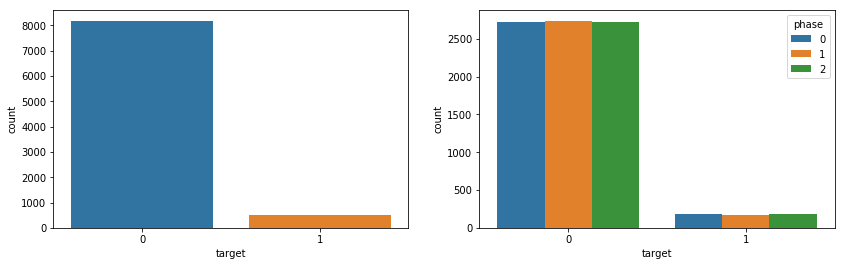

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sns.countplot(x="target", data=Train_df, ax=ax1)
sns.countplot(x="target", data=Train_df, hue="phase", ax=ax2)

In [7]:
train = pq.read_pandas('train.parquet').to_pandas()

Plotting first few signals from the training set



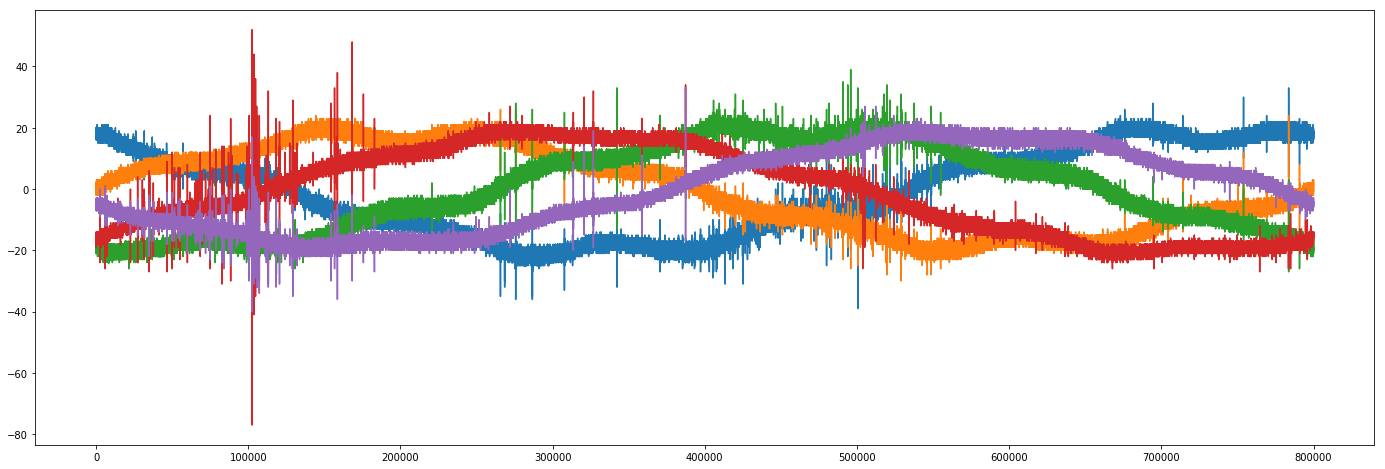

In [8]:
plt.figure(figsize=(24, 8))
plt.plot(train.iloc[:, :5]);

In [9]:
Train_df.head(6)

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1


## Functions


In [10]:
@numba.jit(nopython=True)
def flatiron(x, alpha=50., beta=1):
    """
    Flatten signal
    
    Creator: Michael Kazachok
    Source: https://www.kaggle.com/miklgr500/flatiron
    
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [11]:
@numba.jit(nopython=True)
def drop_missing(intersect,sample):
    """
    Find intersection of sorted numpy arrays
    
    Since intersect1d sort arrays each time, it's effectively inefficient.
    Here you have to sweep intersection and each sample together to build
    the new intersection, which can be done in linear time, maintaining order. 

    Source: https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays
    Creator: B. M.
    """
    i=j=k=0
    new_intersect=np.empty_like(intersect)
    while i< intersect.size and j < sample.size:
        if intersect[i]==sample[j]: # the 99% case
            new_intersect[k]=intersect[i]
            k+=1
            i+=1
            j+=1
        elif intersect[i]<sample[j]:
            i+=1
        else : 
            j+=1
    return new_intersect[:k]

In [12]:
@numba.jit(nopython=True)
def _local_maxima_1d_window_single_pass(x, w):
    
    midpoints = np.empty(x.shape[0] // 2, dtype=np.intp)
    left_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    right_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    m = 0  # Pointer to the end of valid area in allocated arrays

    i = 1  # Pointer to current sample, first one can't be maxima
    i_max = x.shape[0] - 1  # Last sample can't be maxima
    while i < i_max:
        # Test if previous sample is smaller
        if x[i - 1] < x[i]:
            i_ahead = i + 1  # Index to look ahead of current sample

            # Find next sample that is unequal to x[i]
            while i_ahead < i_max and x[i_ahead] == x[i]:
                i_ahead += 1
                    
            i_right = i_ahead - 1
            
            f = False
            i_window_end = i_right + w
            while i_ahead < i_max and i_ahead < i_window_end:
                if x[i_ahead] > x[i]:
                    f = True
                    break
                i_ahead += 1
                                
            # Maxima is found if next unequal sample is smaller than x[i]
            if x[i_ahead] < x[i]:
                left_edges[m] = i
                right_edges[m] = i_right
                midpoints[m] = (left_edges[m] + right_edges[m]) // 2
                m += 1
                
            # Skip samples that can't be maximum
            i = i_ahead - 1
        i += 1

    # Keep only valid part of array memory.
    midpoints = midpoints[:m]
    left_edges = left_edges[:m]
    right_edges = right_edges[:m]
    
    return midpoints, left_edges, right_edges

@numba.jit(nopython=True)
def local_maxima_1d_window(x, w=1):
    """
    Find local maxima in a 1D array.
    This function finds all local maxima in a 1D array and returns the indices
    for their midpoints (rounded down for even plateau sizes).
    It is a modified version of scipy.signal._peak_finding_utils._local_maxima_1d
    to include the use of a window to define how many points on each side to use in
        the test for a point being a local maxima.
    Parameters
    ----------
    x : ndarray
        The array to search for local maxima.
    w : np.int
        How many points on each side to use for the comparison to be True
    Returns
    -------
    midpoints : ndarray
        Indices of midpoints of local maxima in `x`.
    Notes
    -----
    - Compared to `argrelmax` this function is significantly faster and can
      detect maxima that are more than one sample wide. However this comes at
      the cost of being only applicable to 1D arrays.
    """    
        
    fm, fl, fr = _local_maxima_1d_window_single_pass(x, w)
    bm, bl, br = _local_maxima_1d_window_single_pass(x[::-1], w)
    bm = np.abs(bm - x.shape[0] + 1)[::-1]
    bl = np.abs(bl - x.shape[0] + 1)[::-1]
    br = np.abs(br - x.shape[0] + 1)[::-1]

    m = drop_missing(fm, bm)

    return m

In [13]:
@numba.jit(nopython=True)
def plateau_detection(grad, threshold, plateau_length=5):
    """Detect the point when the gradient has reach a plateau"""
    
    count = 0
    loc = 0
    for i in range(grad.shape[0]):
        if grad[i] > threshold:
            count += 1
        
        if count == plateau_length:
            loc = i - plateau_length
            break
            
    return loc


In [14]:
#@numba.jit(nopython=True)
def get_peaks(
    x, 
    window=25,
    visualise=False,
    visualise_color=None,
):
    """
    Find the peaks in a signal trace.
    Parameters
    ----------
    x : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    peaks_x : ndarray
        Indices of midpoints of peaks in `x`.
    peaks_y : ndarray
        Absolute heights of peaks in `x`.
    x_hp : ndarray
        An absolute flattened version of `x`.
    """
    
    x_hp = flatiron(x, 50, 1)
    x_dn = np.abs(x_hp)
    
    peaks = local_maxima_1d_window(x_dn, window)
    
    heights = x_dn[peaks]
    
    ii = np.argsort(heights)[::-1]
    
    peaks = peaks[ii]
    heights = heights[ii]
    
    ky = heights
    kx = np.arange(1, heights.shape[0]+1)
    
    conv_length = 9

    grad = np.diff(ky, 1)/np.diff(kx, 1)
    grad = np.convolve(grad, np.ones(conv_length)/conv_length)#, mode='valid')
    grad = grad[conv_length-1:-conv_length+1]
    
    knee_x = plateau_detection(grad, -0.01, plateau_length=1000)
    knee_x -= conv_length//2
    
    if visualise:
        plt.plot(grad, color=visualise_color)
        plt.axvline(knee_x, ls="--", color=visualise_color)
    
    peaks_x = peaks[:knee_x]
    peaks_y = heights[:knee_x]
    
    ii = np.argsort(peaks_x)
    peaks_x = peaks_x[ii]
    peaks_y = peaks_y[ii]
        
    return peaks_x, peaks_y, x_hp

In [15]:
@numba.jit(nopython=True)
def clip(v, l, u):
    """Numba helper function to clip a value"""
    
    if v < l:
        v = l
    elif v > u:
        v = u
        
    return v

In [16]:
peak_features_names = [
    'ratio_next',
    'ratio_prev',
    'small_dist_to_min',
    'sawtooth_rmse',
]

num_peak_features = len(peak_features_names)

@numba.jit(nopython=True)
def create_sawtooth_template(sawtooth_length, pre_length, post_length):
    """Generate sawtooth template"""
    
    l = pre_length+post_length+1
    
    st = np.zeros(l)
    for i in range(sawtooth_length+1):
        
        j = pre_length+i
        if j < l:
            st[j] = 1 - ((2./sawtooth_length) * i)
        
    return st
@numba.jit(nopython=True)
def calculate_peak_features(px, x_hp0, ws=5, wl=25):
    """
    Calculate features for peaks.
    Parameters
    ----------
    px : ndarray
        Indices of peaks.
    x_hp0 : ndarray
        The array to search.
    ws : np.int
        How many points on each side to use for small window features
    wl : np.int
        How many points on each side to use for large window features
    Returns
    -------
    features : ndarray
        Features calculate for each peak in `x_hp0`.
    """
    
    features = np.ones((px.shape[0], num_peak_features), dtype=np.float64) * np.nan
    
    for i in range(px.shape[0]):
        
        feature_number = 0
        
        x = px[i]
        x_next = x+1
        x_prev = x-1
        
        h0 = x_hp0[x]

        ws_s = clip(x-ws, 0, 800000-1)
        ws_e = clip(x+ws, 0, 800000-1)
        wl_s = clip(x-wl, 0, 800000-1)
        wl_e = clip(x+wl, 0, 800000-1)
        
        ws_pre = x - ws_s
        ws_post = ws_e - x
        
        wl_pre = x - wl_s
        wl_post = wl_e - x
        
        if x_next < 800000:
            h0_next = x_hp0[x_next]
            features[i, feature_number] = np.abs(h0_next)/np.abs(h0)
        feature_number += 1
            
        if x_prev >= 0:
            h0_prev = x_hp0[x_prev]
            features[i, feature_number] = np.abs(h0_prev)/np.abs(h0)
        feature_number += 1
            
        x_hp_ws0 = x_hp0[ws_s:ws_e+1]
        x_hp_wl0 = x_hp0[wl_s:wl_e+1]
        x_hp_wl0_norm = (x_hp_wl0/np.abs(h0))
        x_hp_ws0_norm = (x_hp_ws0/np.abs(h0))
        x_hp_abs_wl0 = np.abs(x_hp_wl0)
        wl_max_0 = np.max(x_hp_abs_wl0)
        
        ws_opp_peak_i = np.argmin(x_hp_ws0*np.sign(h0))
        
        features[i, feature_number] = ws_opp_peak_i - ws
        feature_number += 1
        
        x_hp_wl0_norm_sign = x_hp_wl0_norm * np.sign(h0)
        
        sawtooth_length = 3
        st = create_sawtooth_template(sawtooth_length, wl_pre, wl_post)
        assert np.argmax(st) == np.argmax(x_hp_wl0_norm_sign)
        assert st.shape[0] == x_hp_wl0_norm_sign.shape[0]
        features[i, feature_number] = np.mean(np.power(x_hp_wl0_norm_sign - st, 2))
        feature_number += 1
        
        if i == 0:
            assert feature_number == num_peak_features
        
    return features

In [17]:
def process_signal(
    data,
    window=25,
):
    """
    Process a signal trace to find the peaks and calculate features for each peak.
    Parameters
    ----------
    data : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    px0 : ndarray
        Indices for each peak in `data`.
    height0 : ndarray
        Absolute heaight for each peak in `data`.
    f0 : ndarray
        Features calculate for each peak in `data`.
    """
    
    px0, height0, x_hp0 = get_peaks(
        data.astype(np.float),
        window=window, 
    )
            
    f0 = calculate_peak_features(px0, x_hp0)
    
    return px0, height0, f0

In [18]:
def process_measurement_peaks(data, signal_ids):
    """
    Process three signal traces in measurment to find the peaks
    and calculate features for each peak.
    Parameters
    ----------
    data : ndarray
        Signal traces.
    signal_ids : ndarray
        Signal IDs for each of the signal traces in measurment
    Returns
    -------
    res : ndarray
        Data for each peak in the three traces in `data`.
    sigid_res : ndarray
        Signal ID for each row in `res`.
    """
    res = []
    sigid_res = []
    
    assert data.shape[1] % 3 == 0
    N = data.shape[1]//3
    
    for i in range(N):
        
        sigids = signal_ids[i*3:(i+1)*3]
        x = data[:, i*3:(i+1)*3].astype(np.float)
        
        px0, height0, f0 = process_signal(
            x[:, 0]
        )
        
        px1, height1, f1 = process_signal(
            x[:, 1]
        )
        
        px2, height2, f2 = process_signal(
            x[:, 2]
        )
        
        if px0.shape[0] != 0:
            res.append(np.hstack([
                px0[:, np.newaxis], 
                height0[:, np.newaxis],
                f0,
            ]))
            
            sigid_res.append(np.ones(px0.shape[0], dtype=np.int) * sigids[0])
        
        if px1.shape[0] != 0:
            res.append(np.hstack([
                px1[:, np.newaxis], 
                height1[:, np.newaxis],
                f1,
            ]))

            sigid_res.append(np.ones(px1.shape[0], dtype=np.int) * sigids[1])
        
        if px2.shape[0] != 0:
            res.append(np.hstack([
                px2[:, np.newaxis], 
                height2[:, np.newaxis],
                f2,
            ]))

            sigid_res.append(np.ones(px2.shape[0], dtype=np.int) * sigids[2])
            
    return res, sigid_res

In [19]:
def process_measurement(data_df, meta_df, fft_data):
    """
    Process three signal traces in measurment to find the peaks
    and calculate features for each peak.
    Parameters
    ----------
    data_df : pandas.DataFrame
        Signal traces.
    meta_df : pandas.DataFrame
        Meta data for measurement
    fft_data : ndarray
        50Hz fourier coefficient for three traces
    Returns
    -------
    peaks : pandas.DataFrame
        Data for each peak in the three traces in `data`.
    """
    peaks, sigids = process_measurement_peaks(
        data_df.values, # [:, :100*3], 
        meta_df['signal_id'].values, # [:100*3]
    )
    
    peaks = np.concatenate(peaks)

    peaks = pd.DataFrame(
        peaks,
        columns=['px', 'height'] + peak_features_names
    )
    peaks['signal_id'] = np.concatenate(sigids)
 # Calculate the phase resolved location of each peak

    phase_50hz = np.angle(fft_data, deg=False) # fft_data[:, 1]

    phase_50hz = pd.DataFrame(
        phase_50hz,
        columns=['phase_50hz']
    )
    phase_50hz['signal_id'] = meta_df['signal_id'].values

    peaks = pd.merge(peaks, phase_50hz, on='signal_id', how='left')

    dt = (20e-3/(800000))
    f1 = 50
    w1 = 2*np.pi*f1
    peaks['phase_aligned_x'] = (np.degrees(
        (w1*peaks['px'].values*dt) + peaks['phase_50hz'].values
    ) + 90) % 360
    
    # Calculate the phase resolved quarter for each peak
    peaks['Q'] = pd.cut(peaks['phase_aligned_x'], [0, 90, 180, 270, 360], labels=[0, 1, 2, 3])
    
    return peaks

In [20]:
@numba.jit(nopython=True, parallel=True)
def calculate_50hz_fourier_coefficient(data):
    """Calculate the 50Hz Fourier coefficient of a signal.
    Assumes the signal is 800000 data points long and covering 20ms.
    """

    n = 800000
    assert data.shape[0] == n
    
    omegas = np.exp(-2j * np.pi * np.arange(n) / n).reshape(n, 1)
    m_ = omegas ** np.arange(1, 2)
    
    m = m_.flatten()

    res = np.zeros(data.shape[1], dtype=m.dtype)
    for i in numba.prange(data.shape[1]):
        res[i] = m.dot(data[:, i].astype(m.dtype))
            
    return res

# Preprocessing Overview

Each signal trace is preprocessed to identify the peaks and calculate features.

The steps performed to do this are:

1. Flatten the trace using the flatiron function
2. Identify the local maxima peaks in each trace using the local_maxima_1d_window function
3. Filter the peaks identified in step 2 to separate the signal from the noise
4. Calculate features for each peak identified in step 3 using calculate_peak_features


Step 2. To identify the local maxima the function local_maxima_1d_window is used. This function takes a window length argument, which is the number of points on each side to use for the comparison. An example of the behaviour of this function can be seen below:

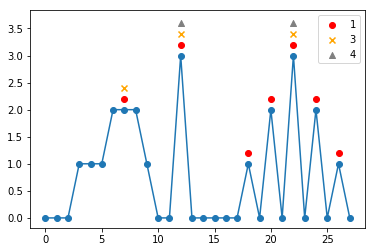

In [21]:
a = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0])

p1 = local_maxima_1d_window(a, w=1)
p3 = local_maxima_1d_window(a, w=3)
p4 = local_maxima_1d_window(a, w=4)

plt.plot(a, marker='o')
plt.scatter(p1, a[p1]+0.2, color='red', label='1')
plt.scatter(p3, a[p3]+0.4, color='orange', marker='x', label='3')
plt.scatter(p4, a[p4]+0.6, color='grey', marker='^', label='4')
plt.legend()
plt.show()


Step 3. Once all the peaks in a trace have been identified, the peaks caused by the noise in the signal need to be removed. This is performed in the get_peaks function. When the peaks are ordered by height, knee detection is performed to identify the point when the height of the peaks stops changing due to the noise floor being reached. The steps are:

1. Order the peaks by their height
2. Calculate the gradient between each consecutive pair of peaks
3. Smooth the gradients using a convolution operation
4. Find the noise floor using the plateau_detection function

The location of the threshold identified for a number of signals can be seen below:

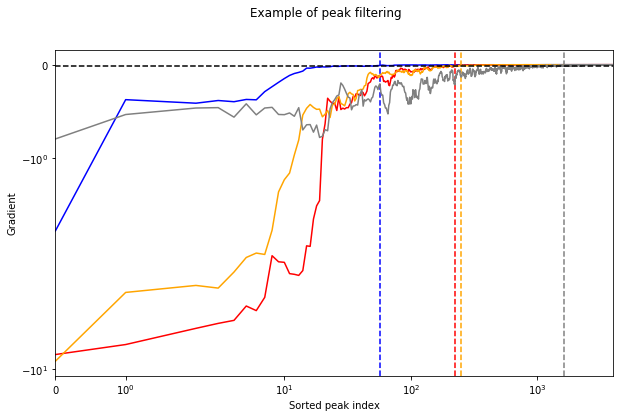

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sigids = [2323, 10, 4200, 4225]
colours = ['blue', 'red', 'orange', 'grey']
for i, sigid in enumerate(sigids):
    d = pq.read_pandas(
        'train.parquet',
        columns=[str(sigid)]
    ).to_pandas().values[:, 0].astype(np.float)
    get_peaks(d, visualise=True, visualise_color=colours[i])

plt.xlim([0, 4000])
plt.axhline(-0.01, color='black', ls='--')
plt.yscale("symlog")
plt.xscale("symlog")

plt.xlabel('Sorted peak index')
plt.ylabel('Gradient')
plt.suptitle('Example of peak filtering')

plt.show()

# Preprocess Train Data


In [23]:
RECALCULATE_PEAK_FEATURES = True

In [24]:
%%time

if RECALCULATE_PEAK_FEATURES:

    train_df = pq.read_pandas(
        'train.parquet'
    ).to_pandas()
    
    train_fft = calculate_50hz_fourier_coefficient(train_df.values)
    
    train_peaks = process_measurement(
        train_df, 
        Train_df, 
        train_fft
    )

    del train_df, train_fft
    gc.collect()

Wall time: 7min 1s


In [25]:
if not RECALCULATE_PEAK_FEATURES:
    train_peaks = pd.read_pickle('train_peaks.pkl')
    
train_peaks.to_pickle("train_peaks.pkl")

In [26]:
train_peaks = pd.merge(train_peaks, Train_df[['signal_id', 'id_measurement', 'target']], on='signal_id', how='left')

# Preprocess Test Data

In [27]:
%%time

if RECALCULATE_PEAK_FEATURES:
    
    NUM_TEST_CHUNKS = 10
    
    test_chunk_size = int(np.ceil((Test_df.shape[0]/3.)/float(NUM_TEST_CHUNKS))*3.)
    
    test_peaks = []

    for j in range(NUM_TEST_CHUNKS):

        j_start = j*test_chunk_size
        j_end = (j+1)*test_chunk_size
        
        signal_ids = Test_df['signal_id'].values[j_start:j_end]

        test_df = pq.read_pandas(
            'test.parquet',
            columns=[str(c) for c in signal_ids]
        ).to_pandas()

        test_fft = calculate_50hz_fourier_coefficient(test_df.values)
        
        p = process_measurement(
            test_df, 
            Test_df.iloc[j_start:j_end], 
            test_fft
        )

        test_peaks.append(p)
        
        print(j)
        
        del test_df
        gc.collect()
        
    del test_fft
    gc.collect()
        
    test_peaks = pd.concat(test_peaks)
    
#Wall time : 12min 2s

0
1
2
3
4
5
6
7
8
9
Wall time: 11min 39s


In [28]:
if not RECALCULATE_PEAK_FEATURES:
    test_peaks = pd.read_pickle('test_peaks.pkl')
    
test_peaks.to_pickle("test_peaks.pkl")

In [29]:
test_peaks = pd.merge(test_peaks, Test_df[['signal_id', 'id_measurement']], on='signal_id', how='left')

In [30]:
USE_SIMPLIFIED_VERSION = False

# Features

In [31]:
def process(peaks_df, meta_df, use_improved=True):

    results = pd.DataFrame(index=meta_df['id_measurement'].unique())
    results.index.rename('id_measurement', inplace=True)
    
    ################################################################################
    
    if not USE_SIMPLIFIED_VERSION:
        # Filter peaks using ratio_next and height features
        # Note: may not be all that important
        peaks_df = peaks_df[~(
            (peaks_df['ratio_next'] > 0.33333)
            & (peaks_df['height'] > 50)
        )]
    
    ################################################################################

    # Count peaks in phase resolved quarters 0 and 2
    p = peaks_df[peaks_df['Q'].isin([0, 2])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ["peak_count_Q02"]
    results = pd.merge(results, res, on='id_measurement', how='left')
        
    ################################################################################
    
    # Count total peaks for each measurement id
    res = peaks_df.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ["peak_count_total"]
    results = pd.merge(results, res, on='id_measurement', how='left')

    ################################################################################

    # Count peaks in phase resolved quarters 1 and 3
    p = peaks_df[peaks_df['Q'].isin([1, 3])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'px': ['count'],
    })
    res.columns = ['peak_count_Q13']
    results = pd.merge(results, res, on='id_measurement', how='left')
    
    ################################################################################
    
    # Calculate additional features using phase resolved quarters 0 and 2
    
    feature_quarters = [0, 2]
    
    p = peaks_df[peaks_df['Q'].isin(feature_quarters)].copy()
    
    p['abs_small_dist_to_min'] = np.abs(p['small_dist_to_min'])
    
    res = p.groupby('id_measurement').agg(
    {
        
        'height': ['mean', 'std'],
        'ratio_prev': ['mean'],
        'ratio_next': ['mean'],
        'abs_small_dist_to_min': ['mean'],        
        'sawtooth_rmse': ['mean'],
    })
    res.columns = ["_".join(f) + '_Q02' for f in res.columns]     
    results = pd.merge(results, res, on='id_measurement', how='left')
        
    return results

In [32]:
def create_features(
    meta_df, 
    peaks_df,
):
    
    res = process(peaks_df, meta_df)
    
    return res

In [33]:
%%time
X_train_full = create_features( 
    Train_df, 
    train_peaks,
)


#Wall time : 1.05 s

Wall time: 844 ms


In [34]:
y_train = (
    Train_df.groupby('id_measurement')['target'].sum().round(0).astype(np.int)
    != 0
).astype(np.float)

assert np.all(y_train.index.values == X_train_full.index.values)

In [35]:
%%time
X_test_full = create_features( 
    Test_df, 
    test_peaks,
)

#Wall time : 1.43 s

Wall time: 1.28 s


In [36]:
default_features_to_drop = [
    'id_measurement',
    'phase',
    'fft_phase',
    'signal_id',
]

In [37]:
if USE_SIMPLIFIED_VERSION:
    additional_features_to_drop = [
        #'peak_count_Q13',
        'abs_small_dist_to_min_mean_Q02',
        'height_mean_Q02',
        #'height_std_Q02',
        #'sawtooth_rmse_mean_Q02',
        #'peak_count_Q02',
        'ratio_next_mean_Q02',
        'ratio_prev_mean_Q02',
        #'peak_count_total' 
    ]
else:
    additional_features_to_drop = []

In [38]:
features_to_drop = (
    default_features_to_drop
    + additional_features_to_drop 
)

In [39]:
if USE_SIMPLIFIED_VERSION:
    feature_names = sorted([c for c in X_train_full.columns if c not in features_to_drop])
else:
    # to maintain consistent order with original version after feature renaming
    feature_names = [
        'peak_count_Q13',
        'abs_small_dist_to_min_mean_Q02',
        'height_mean_Q02',
        'height_std_Q02',
        'sawtooth_rmse_mean_Q02',
        'peak_count_Q02',
        'ratio_next_mean_Q02',
        'ratio_prev_mean_Q02',
        'peak_count_total'   
    ]

In [40]:
X_train = X_train_full[feature_names]
X_test = X_test_full[feature_names]

# Evaluating Matthews Correlation Coefficient 

The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. 


                         MCC =         (TP∗TN)−(FP∗FN)
                               -----------------------------
                               √(TP+FP)(TP+FN)(TN+FP)(TN+FN)




In this equation, TP is the number of true positives, TN the number of true negatives, FP the number of false positives and FN the number of false negatives. If any of the four sums in the denominator is zero, the denominator can be arbitrarily set to one; this results in a Matthews correlation coefficient of zero, which can be shown to be the correct limiting value.



MCC is calculated between the values of -1 and 1, where,

-1 implies bad prediction

0 is as good as a random prediction, and

1 is a good prediction

In [41]:
@numba.jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)

#@numba.jit
def eval_mcc(y_true, y_prob, show=False):
    """
    A fast implementation of Anokas mcc optimization code.

    This code takes as input probabilities, and selects the threshold that 
    yields the best MCC score. It is efficient enough to be used as a 
    custom evaluation function in xgboost
    
    Source: https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc
    Source: https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22917/optimising-probabilities-binary-prediction-script
    Creator: CPMP
    """
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_proba,  best_mcc, None

In [42]:
def train(
    X_data, 
    y_data,
    params,
    feature_names, 
    verbose_eval=50,
    kfold_random_state=23948,
    predict=False,
    calculate_mcc=False,
    early_stopping_rounds=10,
    num_folds=5,
    num_iterations=10,
):
    
    params = copy.deepcopy(params)
    
    models = []
    cv_scores = []
    val_cv_scores = []
    if calculate_mcc:
        mcc_scores = []
        val_mcc_scores = []
        thresholds=[]
    else:
        mcc_scores = None
        val_mcc_scores = None
        thresholds = None
        
    if predict:
        yp_train = np.zeros(X_train.shape[0])
        yp_val = np.zeros(X_train.shape[0])
        yp_test = np.zeros(X_train.shape[0])
    else:
        yp_train = None
        yp_val = None
        yp_test = None
        
    for iter in range(num_iterations):
        
        np.random.seed(kfold_random_state + iter)
        splits = np.zeros(X_data.shape[0], dtype=np.int)
        m = y_data == 1
        splits[m] = np.random.randint(0, 5, size=m.sum())
        m = y_data == 0
        splits[m] = np.random.randint(0, 5, size=m.sum())

        for fold in range(num_folds):

            val_fold = fold
            test_fold = (fold + 1) % num_folds

            train_folds = [f for f in range(num_folds) if f not in [val_fold, test_fold]]

            train_indices = np.where(np.isin(splits, train_folds))[0]
            val_indices = np.where(splits == val_fold)[0]
            test_indices = np.where(splits == test_fold)[0]

            trn = lgb.Dataset(
                X_data.values[train_indices],
                y_data[train_indices],
                feature_name=feature_names,
            )

            val = lgb.Dataset(
                X_data.values[val_indices],
                y_data[val_indices],
                feature_name=feature_names,
            )

            test = lgb.Dataset(
                X_data.values[test_indices],
                y_data[test_indices],
                feature_name=feature_names,
            )

            # train model

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = lgb.train(
                    params, 
                    trn, 
                    #num_boost_round=10000, 
                    valid_sets=(trn, test, val), 
                    valid_names=("train", "test", "validation"), 
                    fobj=None, 
                    feval=None,
                    early_stopping_rounds=early_stopping_rounds,
                    #evals_result=training_data,
                    verbose_eval=verbose_eval,
                )


            yp = None

            if predict:
                yp = model.predict(X_train.values[train_indices])
                yp_train[train_indices] += yp

                yp_val_fold = model.predict(X_train.values[val_indices])
                yp_val[val_indices] += yp_val_fold
                
                yp_test_fold = model.predict(X_train.values[test_indices])
                yp_test[test_indices] += yp_test_fold

            models.append(model)

            s = model.best_score['test']
            cv_scores.append(s[list(s.keys())[0]])

            s = model.best_score['validation']
            val_cv_scores.append(s[list(s.keys())[0]])

            if calculate_mcc:

                # find optimal probability threshold using training data
                best_proba, _, _ = eval_mcc(
                    y_train.values[train_indices].astype(np.float),
                    yp, 
                    False
                )

                # calculate validation MCC score using optimal probability threshold
                best_mcc_val = matthews_corrcoef(
                    y_train.values[val_indices].astype(np.float), 
                    yp_val_fold.astype(np.float) > best_proba
                )

                # calculate test MCC score using optimal probability threshold
                best_mcc = matthews_corrcoef(
                    y_train.values[test_indices].astype(np.float), 
                    yp_test_fold.astype(np.float) > best_proba
                )

                val_mcc_scores.append(best_mcc_val)
                mcc_scores.append(best_mcc)
                thresholds.append(best_proba)

    if yp_train is not None:
        yp_train /= ((num_folds - 2) * num_iterations)
        yp_val /= num_iterations
        yp_test /= num_iterations
            
    cv_scores = np.array(cv_scores)
    val_cv_scores = np.array(val_cv_scores)
    if calculate_mcc:
        mcc_scores = np.array(mcc_scores)
        val_mcc_scores = np.array(val_mcc_scores)
        thresholds = np.array(thresholds)
        
    return (
        models,
        cv_scores, val_cv_scores, 
        mcc_scores, val_mcc_scores, 
        yp_train, yp_val, yp_test, thresholds
    )

# Train

In [43]:
params = {
    'objective': 'binary',
    #'is_unbalance': True,
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 80, # 61,
    'num_threads': 4,
    'metric': 'binary_logloss',
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'seed': 23974,
    'num_boost_round': 10000,
}

In [44]:
%%time

(
    models,
    cv_scores, val_cv_scores, 
    mcc_scores, val_mcc_scores, 
    yp_train, yp_val, yp_test, thresholds
) = train(
    X_train, 
    y_train,
    params,
    feature_names, 
    verbose_eval=0, # 50,
    kfold_random_state=123948,
    predict=True,
    calculate_mcc=True,
    early_stopping_rounds=100,
    num_iterations=25 # 100
)

print("")
print("CV Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(cv_scores.mean(), cv_scores.std()/np.sqrt(cv_scores.shape[0]), cv_scores.std()))
print("CV Val Logloss: {:.4f} +/- {:.4f} ({:.4f})".format(val_cv_scores.mean(), val_cv_scores.std()/np.sqrt(val_cv_scores.shape[0]), val_cv_scores.std()))
print("CV MCC: {:.4f} +/- {:.4f} ({:.4f})".format(mcc_scores.mean(), mcc_scores.std()/np.sqrt(mcc_scores.shape[0]), mcc_scores.std()))
print("CV VAL MCC: {:.4f} +/- {:.4f} ({:.4f})".format(val_mcc_scores.mean(), val_mcc_scores.std()/np.sqrt(val_mcc_scores.shape[0]), val_mcc_scores.std()))
print("Threshold {:.4f} +/- {:.4f}".format(thresholds.mean(), thresholds.std()/np.sqrt(thresholds.shape[0])))

##################################

best_proba_meas, _, _ = eval_mcc(
    y_train.values.astype(np.float),
    yp_train, 
    False
)

best_mcc_meas = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_val > best_proba_meas
)

best_mcc_meas_test = matthews_corrcoef(
    y_train.values.astype(np.float), 
    yp_test > best_proba_meas
)

plt.show()

##################################

yp_train_df = pd.DataFrame(
    yp_train,
    index=X_train_full.index
)

yp_val_df = pd.DataFrame(
    yp_val,
    index=X_train_full.index
)

yp_test_df = pd.DataFrame(
    yp_test,
    index=X_train_full.index
)

train_pred = Train_df[['id_measurement', 'signal_id', 'target']].copy()
train_pred = pd.merge(train_pred, yp_train_df, on='id_measurement')
train_pred.rename({0:'prediction'}, axis=1, inplace=True)

val_pred = Train_df[['id_measurement', 'signal_id', 'target']].copy()
val_pred = pd.merge(val_pred, yp_val_df, on='id_measurement')
val_pred.rename({0:'prediction'}, axis=1, inplace=True)

test_pred = Train_df[['id_measurement', 'signal_id', 'target']].copy()
test_pred = pd.merge(test_pred, yp_test_df, on='id_measurement')
test_pred.rename({0:'prediction'}, axis=1, inplace=True)

best_proba, _, _ = eval_mcc(
    train_pred['target'].values.astype(np.float),
    train_pred['prediction'].values.astype(np.float),
    False
)

best_mcc = matthews_corrcoef(
    val_pred['target'].values.astype(np.float), 
    val_pred['prediction'].values.astype(np.float) > best_proba
)

best_mcc_test = matthews_corrcoef(
    test_pred['target'].values.astype(np.float), 
    test_pred['prediction'].values.astype(np.float) > best_proba
)

##################################

plt.show()

print("MCC (measurement): {:.3f}".format(best_mcc_meas))
print("MCC Test (measurement): {:.3f}".format(best_mcc_meas_test))
print("Best Probability Threshold(measurement): {:.3f}".format(best_proba_meas))

print("MCC: {:.3f}".format(best_mcc))
print("MCC Test: {:.3f}".format(best_mcc_test))
print("Best Probability Threshold: {:.3f}".format(best_proba))


CV Logloss: 0.0981 +/- 0.0014 (0.0159)
CV Val Logloss: 0.0983 +/- 0.0015 (0.0162)
CV MCC: 0.7148 +/- 0.0051 (0.0572)
CV VAL MCC: 0.7153 +/- 0.0049 (0.0543)
Threshold 0.3551 +/- 0.0051
MCC (measurement): 0.711
MCC Test (measurement): 0.713
Best Probability Threshold(measurement): 0.299
MCC: 0.715
MCC Test: 0.713
Best Probability Threshold: 0.369
Wall time: 1min 33s


# Test and Submit

In [45]:
X_test.head()


,peak_count_Q13,abs_small_dist_to_min_mean_Q02,height_mean_Q02,height_std_Q02,sawtooth_rmse_mean_Q02,peak_count_Q02,ratio_next_mean_Q02,ratio_prev_mean_Q02,peak_count_total
id_measurement,,,,,,,,,
2904,290.0,1.484163,7.425143,4.009624,0.078244,221,0.554138,0.434405,511
2905,36.0,5.000000,6.501553,0.197004,0.163236,31,0.448624,0.377635,67
2906,62.0,3.761905,7.955978,1.035703,0.186225,42,0.614419,0.589192,104
2907,91.0,2.160000,6.801500,3.512801,0.100066,75,0.434264,0.328138,166
2908,38.0,4.281250,4.787615,0.597925,0.169653,32,0.766745,0.634935,70


In [46]:
X_test.shape, Test_df.shape


((6779, 9), (20337, 3))

In [47]:
len(models)


125

In [48]:
%%time

yp_test = np.zeros(X_test.shape[0])

for j in range(len(models)):
    
    model = models[j]

    yp_test += model.predict(X_test.values)/len(models)

Wall time: 8.77 s


In [49]:
test_submission = pd.DataFrame(
    yp_test,
    index=X_test.index,
    columns=['probability']
)

In [50]:
test_submission['probability_thresholded'] = (yp_test > best_proba).astype(np.int)


In [51]:
test_submission = pd.merge(
    Test_df[['id_measurement', 'signal_id']],
    test_submission,
    on='id_measurement',
    how='left'
)

In [52]:
test_submission['probability_thresholded'].sum()

729

In [53]:
submission = pd.read_csv('sample_submission.csv')

In [54]:
assert np.all(submission['signal_id'].values == test_submission['signal_id'].values)

submission['target'] = test_submission['probability_thresholded'].values

In [55]:
submission.head()


,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


In [56]:
submission.to_csv('submission.csv', index=False)

# Score Analysis


•	As of this competition, my public score is 0.68008 on the public leaderboard with the highest score being 0.83490

•	On the Private leaderboard, my score is 0.71899 and 0.71292 which is in the top 1%


# Summary 


•	In this practice competition, I have summarized the best kernel that I found on the public board which was clear to understand and apply.

•	As my own contribution, I made tweaks to the 'flatiron' function changing the peak alpha values.

•	With changes in these values, I observed changes with the score in public board. As per my observation, with low alpha value, I saw my score dropping to 0.67477 from 0.68008.

•	Hence, my modification/tweak did not work in my favor. 

•	I also performed additional data evaluation and plotted graphs to understand the dataset.

•	Also, I changed the values of the input parameter giving the phases instead of id_measurement. This does not work well in analysing the data as using the 'Group by' function for phase can yield completely different and erratic results. Each phase is a group of signals 0,1 and 2.


# Conclusion

•	In conclusion, a good enough solution has been developed to detect partial discharge in the faulty power lines. With this result, a considerable amount of cost reduction and power outage can be reduced.

•	As with Matthews correlation coefficient, we have successfully achieved a score which is considerably close to 1 (which is considered a good MCC score).

•	With the public score of 0.688 ~ 0.7 and a private score of 0.718, we are close to the perfect MCC score of 1.

•	With further analysis and work, this score maybe improved which can further help with the problem.

•	In conclusion, I have learnt a lot from this particular competition and was introduced to several new topics that are extremely challenging and convoluted.


# Contributions 

By me - 20%
External sources - 80%


# Citations 

I am extremely grateful to the following kernels and referral materials -

https://www.kaggle.com/ehsanolyaee/vsb-power-line-fault-detection

https://www.kaggle.com/rishabhiitbhu/eda-vsb-power-line-fault-detection

https://www.kaggle.com/go1dfish/basic-eda

https://www.kaggle.com/mark4h/vsb-1st-place-solution

https://www.kaggle.com/miklgr500/flatiron

https://en.wikipedia.org/wiki/Matthews_correlation_coefficient

https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22917/optimising-probabilities-binary-prediction-script

https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays

https://www.kaggle.com/cpmpml/optimizing-probabilities-for-best-mcc


# License

Copyright 2019 Vishaka Varma Vimal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.